In [1]:
from azure.quantum import Workspace
import math
from IPython.display import display, clear_output
workspace = Workspace (
    subscription_id = "b1d7f7f8-743f-458e-b3a0-3e09734d716d",
    resource_group = "aq-hackathons",
    name = "aq-hackathon-01",
    location = "eastus"
)


In [2]:
!pip install qiskit-aer --quiet
!pip install azure-quantum[qiskit] --quiet
!pip install termcolor --quiet
!pip install matplotlib --quiet

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
from qiskit import *
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider(
    subscription_id = "b1d7f7f8-743f-458e-b3a0-3e09734d716d",
    resource_group = "aq-hackathons",
    name = "aq-hackathon-01",
    location = "eastus"
)
from qiskit.quantum_info import Statevector
from qiskit.extensions import Initialize
import numpy as np
simulator = Aer.get_backend('statevector_simulator')
quantum_computer = provider.get_backend('ionq.q')

In [4]:
def getStatevector(statevector_id):
    state = []
    if(statevector_id==0):
        state = Statevector([1,0,0,0])
    elif(statevector_id==1):
        state = Statevector([0,1,0,0])
    elif(statevector_id==2):
        state = Statevector([0,0,1,0])
    elif(statevector_id==3):
        state = Statevector([0,0,0,1])
    elif(statevector_id==4):
        state = Statevector(np.array([1,0,0,1])*1/np.sqrt(2))
    elif(statevector_id==5):
        state = Statevector(np.array([1,1,0,0])*1/np.sqrt(2))
    elif(statevector_id==6):
        state = Statevector(np.array([1,0,1,0])*1/np.sqrt(2))
    elif(statevector_id==7):
        state = Statevector(np.array([0,1,0,1])*1/np.sqrt(2))
    elif(statevector_id==8):
        state = Statevector(np.array([0,0,1,1])*1/np.sqrt(2))
    elif(statevector_id==9):
        state = Statevector(np.array([0,1,1,0])*1/np.sqrt(2))
    elif(statevector_id==10):
        state = Statevector(np.array([-1,0,0,1])*1/np.sqrt(2))
    elif(statevector_id==11):
        state = Statevector(np.array([-1,1,0,0])*1/np.sqrt(2))
    elif(statevector_id==12):
        state = Statevector(np.array([-1,0,1,0])*1/np.sqrt(2))
    elif(statevector_id==13):
        state = Statevector(np.array([0,-1,0,1])*1/np.sqrt(2))
    elif(statevector_id==14):
        state = Statevector(np.array([0,0,1,-1])*1/np.sqrt(2))
    elif(statevector_id==15):
        state = Statevector(np.array([0,-1,1,0])*1/np.sqrt(2))
    elif(statevector_id==16):
        state = Statevector(np.array([1,-1,1,1])*1/2)
    elif(statevector_id==17):
        state = Statevector(np.array([1,1,-1,1])*1/2)
    elif(statevector_id==18):
        state = Statevector(np.array([1,1,1,-1])*1/2)
    elif(statevector_id==19):
        state = Statevector(np.array([-1,1,1,1])*1/2)
    elif(statevector_id==20):
        state = Statevector(np.array([-1,-1,1,1])*1/2)
    elif(statevector_id==21):
        state = Statevector(np.array([1,-1,-1,1])*1/2)
    elif(statevector_id==22):
        state = Statevector(np.array([-1,1,-1,1])*1/2)
    elif(statevector_id==23):
        state = Statevector(np.array([1,1,1,1])*1/2)
        #return the statevector
    return state

In [5]:
#INITIALIZE QC
def initializeQuantumCircuit(statevector_ids):
    qc = QuantumCircuit(2)
    player_statevector = getStatevector(statevector_ids[0])
    target_statevector = getStatevector(statevector_ids[1])
    init_gate = Initialize(player_statevector)
    qc.append(init_gate,[0,1])
    return qc

In [6]:
def advanceTurnAux(gate,target_statevector,qc):
    if(gate=="h0"):
        qc.h(0)
    elif(gate=="h1"):
        qc.h(1)
    elif(gate=="x0"):
        qc.x(0)
    elif(gate=="x1"):
        qc.x(1)
    elif(gate=="z0"):
        qc.z(0)
    elif(gate=="z1"):
        qc.z(1)
    elif(gate=="cx0"):
        qc.cx(0,1)
    elif(gate=="cx1"):
        qc.cx(1,0)
    elif(gate=="swap"):
        qc.swap(0,1)
    else:
        return Exception
    qc.barrier()
    #need to run circuit on simulator here
    job_sim = execute(qc,simulator,shots=1024)
    currStatevector = job_sim.result().get_statevector(qc)
    #compute inner product using get_statevector
    innerProd = currStatevector.inner(target_statevector)
    #return pretty version of statevector (so that player can see their current statevector) and inner product
    return [qc, currStatevector, innerProd]

In [7]:
def advanceTurn(gate, target_statevector_id,qc):
    target_statevector = getStatevector(target_statevector_id)
    return advanceTurnAux(gate,target_statevector,qc)

In [8]:
def endGameMeasure(qc, target_sv):
    #need to measure in the basis of the target statevector - we can achieve this by
    #applying a gate that would take the target statevector to the Z basis and 
    #measure in the Z basis. 
    init_gate = Initialize(target_sv)
    inverse_init_gate = init_gate.gates_to_uncompute()
    qc.append(inverse_init_gate,[0,1])
    qc.measure_all()
    real_job = execute(qc,quantum_computer,shots=1024, qobj_header='val')
    counts = real_job.result().get_counts()
    if counts.get('00') is None: 
        return [False, counts] #loss
    if(counts.get('00')>=1024*0.8):
        return [True, counts] #win
    else:
        return [False, counts] #loss

In [9]:
import random
import re

VICTORY_INNER_PRODUCT = 1

responses = [
    "h",
    "z",
    "x"
]

# Method returns first char (h,c,z,y,x,s) and target qubit (1 or 2 or n/a)

def simplify_input(s):
    out = s.replace(" ", "")
    out = out.lower()

    # Selecting closest word in responses to input
    '''match = re.match(r"([a-z]+)([0-9]+)", out, re.I)
    if match:
        items = match.groups()
     temp = difflib.get_close_matches(items[0], responses, 1)'''

    # swap gates don't need target qubits
    if out == "swap":
        return out

    # return 2 chars for cnot/cx gate
    if out[-1] == "0" or out[-1] == "1":
      if (out[0] == 'c'):
          return "cx" + out[-1]
      if out[0] in responses:
        return out[0] + out[-1]



def calculate_values(gate, state_vector, target_vector):
    """Returns inner product and new state vector"""
    return random.random() * 10, random.randint(0, 23)

#general respones, ideally to be done in order

# TODO: add more responses up to 8

correct_responses = [
    "You got your crush's number!",
    "Your crush winked at you!",
    "A friend tells you that your crush likes you.",
    "Your crush laughed the most at your joke today ... this is getting good!",
    "You went to a movie with your crush, they even bought you popcorn!",
    "You built up the courage and asked her to be your valentine, what will be her answer??"
]

wrong_responses = [
    "Your crush ignored you at a gathering.",
    "You tripped and fell and ... your crush laughed at you.",
    "Your crush unfollowed you on instagram :(",
    "Your crush waved at you and you waved ba- oh wait... she was waving at the person behind you.",
    "You just saw your crush flirting with your least favorite person, how rude!",
    "Hmm your crush is holding hands with someone else, it might be too late now."
]

opponent_responses = [
  "opponent 1",
  "opponent 2",
  "opponent 3",
  "opponent 4",
  "opponent 5",
  "opponent 6",
  "opponent 7",
  "opponent 8"
]

#final responses for either win or lose
winning_response = "She said yes!! You officially have a valentine right in time for Valentine's Day"
losing_response = "Uh oh, looks like you have no valentine this year because you've been rejected... better luck next time, never give up!"
# TODO: fix versus losing response
versus_losing_response = "Opponent losing response"

In [ ]:
# Machine Learning section
# ONLY RUN THIS CELL IN A LOCAL ENVIRONMENT (missing model file in Azure environment)

from keras.models import Sequential
from keras.layers import Dense, Flatten

from ValentinesEnv import ValentinesEnv, gates

from copy import deepcopy

model = Sequential()
model.add(Flatten(input_shape=(1, 49)))
model.add(Dense(300, activation="relu"))
model.add(Dense(300, activation="relu"))
model.add(Dense(300, activation="relu"))
model.add(Dense(9, activation="relu"))

model.load_weights("dql-networks\\final.h5f")

env = ValentinesEnv()

Your target statevector is: [0.5,  0.5,  0.5,  0.5]
Your statevector is: [-0.5,  -0.5,  -0.5,  0.5]
Your inner product is: -0.5
Current quantum circuit: 
     ┌───────────────────────────────┐      ░ ┌───┐ ░       ░     ░ ┌───┐ ░ »
q_0: ┤0                              ├──────░─┤ Z ├─░───────░──X──░─┤ X ├─░─»
     │  Initialize(0.5,0.5,0.5,-0.5) │┌───┐ ░ └───┘ ░ ┌───┐ ░  │  ░ └─┬─┘ ░ »
q_1: ┤1                              ├┤ Z ├─░───────░─┤ X ├─░──X──░───■───░─»
     └───────────────────────────────┘└───┘ ░       ░ └───┘ ░     ░       ░ »
«           ░       ░ ┌───┐ ░ 
«q_0: ──■───░───────░─┤ H ├─░─
«     ┌─┴─┐ ░ ┌───┐ ░ └───┘ ░ 
«q_1: ┤ X ├─░─┤ H ├─░───────░─
«     └───┘ ░ └───┘ ░       ░ 
A friend tells you that your crush likes you.
Time is up! You asked your crush out and are waiting for your their response. It feels like an eternity waiting for the response... (the real quantum computer just has long queue times)
(Here, we are measuring your statevector and seeing how many times it

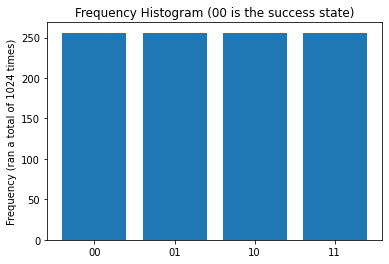

In [10]:
# !pip install termcolor --quiet
# !pip install matplotlib --quiet
import matplotlib.pyplot as plt
from termcolor import colored
from qiskit.visualization import plot_histogram
def clean_inner_product(inner_prod):
    inner_prod_float = np.real(inner_prod).item()   
    print("Your inner product is: " + str(round(inner_prod_float, 2)))

def clean_sv(player_sv):
    player_sv_part = []
    prob = player_sv.probabilities()
    for x in range(4):
        temp = np.real(player_sv[x]).item()
        if (temp == 0):
            player_sv_part.append(0.0)
        else:
            player_sv_part.append(round(temp, 2))
    print("Your statevector is: [", end="")
    for x in player_sv_part[:-1]:
        print(str(x) + ", ", end=" "),
    print(str(player_sv_part[-1]) + "]")    

def clean_target_sv(player_sv):
    player_sv_part = []
    prob = player_sv.probabilities()
    for x in range(4):
        temp = np.real(player_sv[x]).item()
        if (temp == 0):
            player_sv_part.append(0.0)
        else:
            player_sv_part.append(round(temp, 2))
    print("Your target statevector is: [", end="")
    for x in player_sv_part[:-1]:
        print(str(x) + ", ", end=" "),
    print(str(player_sv_part[-1]) + "]") 

print("▀██▀─▄███▄─▀██─██▀██▀▀█\n",
"─██─███─███─██─██─██▄█\n",
"─██─▀██▄██▀─▀█▄█▀─██▀█\n",
"▄██▄▄█▀▀▀─────▀──▄██▄▄█")
print("Welcome to Quantum Valentine’s Day Dating!")
# TODO: cases where they type in something other than y or n
versus = input("Would you like to play in solo mode or versus mode? Type y/n (y for versus and n for solo):") == "y"
print(f"Starting the game in {'versus' if versus else 'solo'} mode!")

player_sv_id = random.randint(0,23)
target_sv_id = random.randint(0,23)
while(player_sv_id==target_sv_id):
    target_sv_id = random.randint(0,23)

if versus:
  observation = deepcopy(env.reset())

turn = 1

qc = initializeQuantumCircuit([player_sv_id, target_sv_id])

#compute initial inner product, print that and initial statevector
player_sv = getStatevector(player_sv_id)
target_sv = getStatevector(target_sv_id)
prev_inner_prod = player_sv.inner(target_sv)

clean_target_sv(target_sv)
clean_sv(player_sv)

clean_inner_product(prev_inner_prod)

check_gate = ["h0","h1","x0","x1","z0","z1","cx0","cx1","swap"]

# Initialization to make the compiler happy (doesn't do anything since when the else statement is called the variables are already definend)
curr_statevector = player_sv
new_inner_prod = prev_inner_prod

while True:
    gate = None
    boolCheck = True
    while boolCheck:
        # Explain which gates, the function of the gates, and how the input works (esp for the CNOT gates)
        print("The available gates are H, X, Z, CNOT, SWAP. Please indicate which qubit to put the gate on for single qubit gates and which one is the target for the CNOT gate. (e.g. for H on the 1st qubit - h0, for CNOT with 2nd qubit as control and 1st as target - cx1")
        gate = simplify_input(
            input("Enter a gate to modify the state vector: "))
        if gate not in check_gate:
            clear_output()
            if (turn == 1):
                clean_target_sv(target_sv)
                clean_sv(player_sv)
                clean_inner_product(prev_inner_prod)
            else:
                clean_target_sv(target_sv)
                clean_sv(curr_statevector)
                clean_inner_product(new_inner_prod)
            print("You entered an invalid gate, please try again.")
        else:
            boolCheck = False
    boolCheck = True
    qc, curr_statevector, new_inner_prod = advanceTurn(
        gate, target_sv_id, qc)
    clear_output()
    clean_target_sv(target_sv)
    clean_sv(curr_statevector)
    clean_inner_product(new_inner_prod)
    print('Current quantum circuit: ')
    print(qc)

    done = False
    if versus:
      action_values = model.predict(np.array([[observation]]))[0]
      action = action_values.argmax(axis=0)
      observation, reward, done, info = env.step(action)
      observation = deepcopy(observation)
      print(f"Your opponent chose to use a {gates[action]} gate.")
      # last element of observation is the model's new inner product
      if observation[48] > new_inner_prod:
        print(opponent_responses[turn])
      else:
        print(correct_responses[turn])
    
    else:
      if(prev_inner_prod < new_inner_prod):
          print(colored(correct_responses[np.mod(turn,6)],'red'))
      else:
          print(colored(wrong_responses[np.mod(turn,6)],'red'))

    if done or new_inner_prod > 0.99  or turn >= 8:
        print(colored('Time is up! You asked your crush out and are waiting for your their response. It feels like an eternity waiting for the response... (the real quantum computer just has long queue times)','red'))
        print('(Here, we are measuring your statevector and seeing how many times it becomes measured in the target statevector basis (win - 80% success rate). We measure in the target statevector basis by applying a gate that would take the target statevector to the Z basis and measure in the Z basis - so a success will be a 00 measured.)')
        win, counts = endGameMeasure(qc,target_sv)
        if win:
            print(colored(winning_response,'green'))
            print(colored('Congratulations on winning! Below is the circuit you produced - we hope your love will develop into something as beautiful as this.','green'))
            print(qc)
            print("── ── ██ ██ ██ ── ── ── ██ ██ ██\n",
"── ██ ██ ██ ██ ██ ── ██ ██ ██ ██ ██\n",
"██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██\n",
"██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██\n"
"██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██\n",
"██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██\n",
"── ██ ██ ██ ██ ██ ██ ██ ██ ██ ██ ██\n"
"── ── ██ ██ ██ ██ ██ ██ ██ ██ ██\n"
"── ── ── ██ ██ ██ ██ ██ ██ ██\n"
"── ── ── ── ██ ██ ██ ██ ██\n"
"── ── ── ── ── ██ ██ ██\n"
"── ── ── ── ── ── ██\n")
        else:
            print(versus_losing_response if versus else colored(losing_response,'blue'))
            print("  _♥__♥_____♥__♥__\n",
"_♥_____♥_♥_____♥\n",
"_♥______♥______♥\n",
"__♥_____/______♥\n",
"___♥____\_____♥\n",
"____♥___/___♥__\n",
"______♥_\_♥____\n",
"________♥______\n"
)
            print(colored("Below is your histogram for future reference. Many other fish out there!",'blue'))
            plt.bar(counts.keys(), counts.values())
            plt.title('Frequency Histogram (00 is the success state)')
            plt.ylabel('Frequency (ran a total of 1024 times)')
            plt.show()
            print('The histogram is different from what you would expect from the final statevector since we have effectively switched the measurement basis to the target statevector basis.')
        break
        
    prev_inner_prod = new_inner_prod
    turn += 1